In [1]:
import os
import shutil
import sys

import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch

### Model

In [2]:
class VAE_Anomaly(nn.Module):
  def __init__(self, args):
    super(VAE_Anomaly, self).__init__()
    self.n_hidden = args.n_hidden
    self.n_latent = args.n_latent
    self.n_input = args.n_input 
    self.encode_1 = nn.Linear(self.n_input, self.n_hidden)
    self.encode_2_mu = nn.Linear(self.n_hidden, self.n_latent)
    self.encode_2_var =  nn.Linear(self.n_hidden, self.n_latent)
    self.decode_1 = nn.Linear(self.n_latent, self.n_hidden)
    self.decode_2 = nn.Linear(self.n_hidden, self.n_input)
    
  def encode(self, input):
    h = self.encode_1(input)
    h = F.relu(h)
    return self.encode_2_mu(h), self.encode_2_var(h)

  def get_z(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    #eps = torch.randn_like(std).to(torch.device(args.cuda))
    eps = torch.normal(mean=0.0, std=0.05*torch.ones_like(std).to(torch.device(args.cuda)))
    return eps.mul(std).add_(mu)

  def decode(self, z):
    x = self.decode_1(z)
    x = F.relu(x)
    x = self.decode_2(x)
    return torch.sigmoid(x)

  def forward(self, input):
    X = input.view(-1, args.n_input)
    mu_z, logvar_z = self.encode(X)
    z = self.get_z(mu_z, logvar_z)
    x_hat = self.decode(z)
    return x_hat, mu_z, logvar_z
    

def loss_function(x, x_hat, mu_z, logvar_z, beta=1.0):
  #loglike = torch.mean(- torch.sum(logvar_x) - torch.sum( torch.square(x.view(-1, 28*28)-mu_x)/torch.exp(logvar_x) ))
  kl_q_p = 0.5*torch.mean(mu_z.pow(2) + logvar_z.exp() - logvar_z)
  xent = F.binary_cross_entropy(x_hat, x.view(-1, 28*28), reduce='mean') 
  ELBO = -xent - beta*kl_q_p
  return -ELBO

### Data Loader

In [3]:
from torchvision import datasets, transforms
import torchvision

download_root = os.path.join(os.getcwd(), '/MNIST_DATASET/')

# MNIST Dataset
train_dataset = datasets.MNIST(root=download_root, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=download_root, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


Extracting /MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to /MNIST_DATASET/MNIST/raw


Extracting /MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST_DATASET/MNIST/raw



Extracting /MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST_DATASET/MNIST/raw


Extracting /MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST_DATASET/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([128, 1, 28, 28])


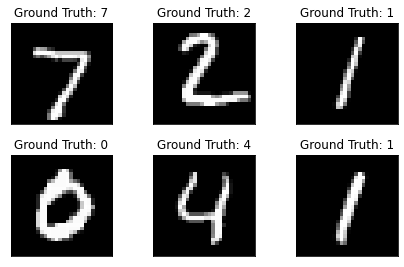

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Set up for training

In [6]:
import torch.optim as optim

args = type('args', (), {})()
args.n_hidden = 400
args.n_latent = 200
args.n_input = 28*28
args.seed = 1111
args.cuda = "cuda" if torch.cuda.is_available() else "cpu"
args.batch_size = 128
args.epochs = 20
args.lr = 0.01

device = torch.device(args.cuda)
vae = VAE_Anomaly(args).to(device)
optimizer = optim.Adam(vae.parameters())

### Train

In [7]:
def train(vae, loss_function, args, train_loader):
  vae.train()
  train_loss = 0.0
  global cnt_update
  
  for batch_idx, (data, targets) in enumerate(train_loader):
    X = data.to(device)

    optimizer.zero_grad()
    X_hat, mu_z, logvar_z = vae(X)
    loss = loss_function(X, X_hat, mu_z, logvar_z)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    cnt_update += 1
    if batch_idx%100==0:
      print(batch_idx, " : " , loss.item()/len(data))
  
  train_loss /= len(train_loader.dataset)
  return train_loss

def evaluate(vae, loss_function, args, test_loader):
  vae.eval()
  total_loss = 0.0
  global cnt_update
  
  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
      X = data.to(device)
      X_hat, mu_z, logvar_z = vae(X)
      loss = loss_function(X, X_hat, mu_z, logvar_z)
      total_loss += loss.item()
      cnt_update += 1

  total_loss /= len(test_loader.dataset)
  return total_loss


In [8]:
cnt_update = 0
for epoch in range(1, args.epochs + 1):
  loss_train = train(vae, loss_function, args, train_loader)
  print(epoch , loss_train)
  loss_test = evaluate(vae, loss_function, args, test_loader)
  print(loss_test)
  #loss_val, n10, r5, r10, kl_val = evaluate(vae, criterion, vad_data_tr, vad_data_te, args)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0  :  0.009359272196888924
100  :  0.005771777592599392
200  :  0.00539895286783576
300  :  0.005208322312682867
400  :  0.005112983752042055
1 0.005519805482029915
0.005077603548765183
0  :  0.0049974350258708
100  :  0.004979896359145641
200  :  0.004908307455480099
300  :  0.00480955746024847
400  :  0.004877428989857435
2 0.004916225398580234
0.004865516883134842
0  :  0.004889416042715311
100  :  0.004803613759577274
200  :  0.004738569725304842
300  :  0.00475913193076849
400  :  0.004707117099314928
3 0.004779351483782133
0.0047816700637340545
0  :  0.004737195558845997
100  :  0.0047262078151106834
200  :  0.004702208563685417
300  :  0.0047160061076283455
400  :  0.004688927438110113
4 0.004721583624680837
0.00474086788892746
0  :  0.004696941934525967
100  :  0.004700448829680681
200  :  0.004695223644375801
300  :  0.004648092668503523
400  :  0.004664996638894081
5 0.004685266548395157
0.0047115544974803926
0  :  0.00471405079588294
100  :  0.004634031560271978
200  :  0.00

### Test

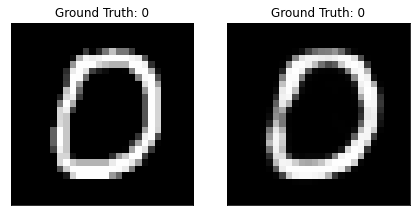

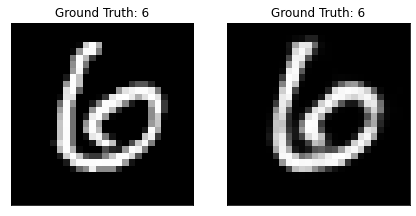

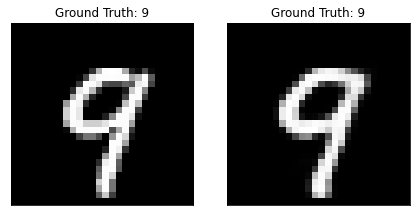

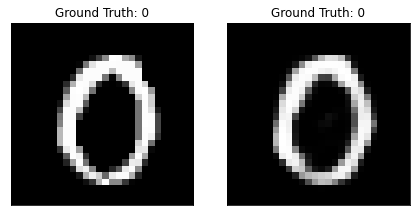

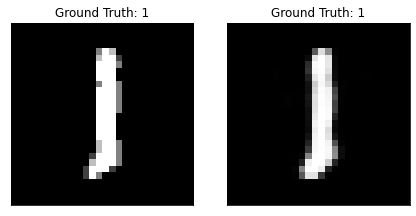

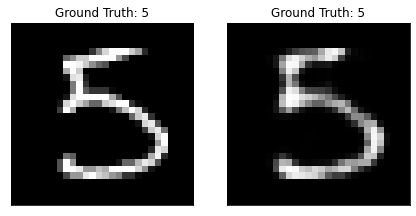

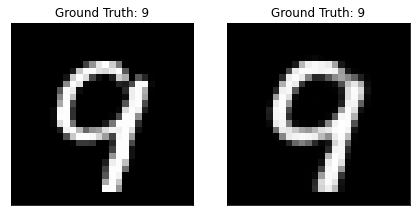

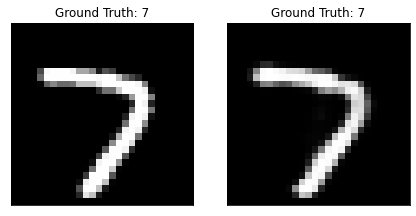

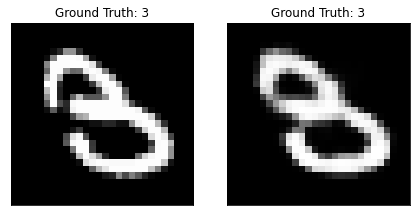

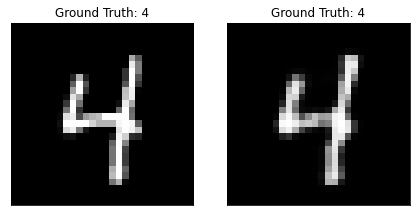

In [9]:
from matplotlib import pyplot as plt
with torch.no_grad():
  for batch_idx, (example_data, example_targets) in enumerate(test_loader):
    for i in range(10, 20):
      fig = plt.figure()
      plt.subplot(1, 2, 1)
      plt.tight_layout()
      plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
      plt.title("Ground Truth: {}".format(example_targets[i]))
      plt.xticks([])
      plt.yticks([])

      plt.subplot(1, 2, 2)
      plt.tight_layout()
      input = example_data[i][0].cuda()
      x_hat, mu_z, logvar_z = vae.forward(input)
      plt.imshow(x_hat.cpu().view(example_data[i][0].shape), cmap='gray', interpolation='none')
      plt.title("Ground Truth: {}".format(example_targets[i]))
      plt.xticks([])
      plt.yticks([])
      plt.show()
    break

### DataLoader for Anomaly Detection

In [10]:
ano_cls = 0
x_nor_train, y_nor_train = train_dataset.data[train_dataset.targets != ano_cls], train_dataset.targets[train_dataset.targets != ano_cls]
x_abn_train, y_abn_train = train_dataset.data[train_dataset.targets == ano_cls], train_dataset.targets[train_dataset.targets == ano_cls] #not used for train
x_nor_test, y_nor_test = test_dataset.data[test_dataset.targets != ano_cls], test_dataset.targets[test_dataset.targets != ano_cls]
x_abn_test, y_abn_test = test_dataset.data[test_dataset.targets == ano_cls], test_dataset.targets[test_dataset.targets == ano_cls]

print(x_nor_train.shape, x_abn_train.shape, x_nor_test.shape, x_abn_test.shape)

torch.Size([54077, 28, 28]) torch.Size([5923, 28, 28]) torch.Size([9020, 28, 28]) torch.Size([980, 28, 28])


In [ ]:
y_nor_train = torch.zeros_like(y_nor_train)
y_abn_train = torch.ones_like(y_abn_train)
y_nor_test = torch.zeros_like(y_nor_test)
y_abn_test = torch.ones_like(y_abn_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


AttributeError: ignored